In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm 
import pandas as pd

In [2]:
def conv_batch(in_num, out_num, kernel_size=5, padding=2, stride=1):
    return nn.Sequential(
        nn.Conv1d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm1d(out_num),
        nn.ReLU())

In [3]:
def make_layer(self, block, in_channels, num_blocks):
    layers = []
    for i in range(0, num_blocks):
        layers.append(block(in_channels))
    return nn.Sequential(*layers)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, ks, pd):
        super(ResidualBlock, self).__init__()
        rc = int(np.ceil(in_channels/2))
        self.layer1 = conv_batch(in_channels, rc, kernel_size=1, padding=0)
        self.layer2 = conv_batch(rc, in_channels, kernel_size=ks, padding=pd)

    def forward(self, x):
        
        residual = x
        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        
        return out

In [5]:
class CNNclassifier(nn.Module):
    def __init__(self, block, num_classes):
        super(CNNclassifier, self).__init__()
        
        #kernel 3 pad 1
        self.k3_conv1 = conv_batch(1,36,kernel_size=3,padding=1,stride=1)
        self.k3_conv2 = conv_batch(36,64,kernel_size=3,padding=1,stride=1)
        self.k3_block1 = self.make_layer(block, in_channels=64, ks=3, pd=1, num_blocks=2)
        self.k3_mp1 = nn.MaxPool1d(kernel_size=3,stride=2,padding=0)
        self.k3_block2 = self.make_layer(block, in_channels=64, ks=3, pd=1, num_blocks=4)
        self.k3_mp2 = nn.MaxPool1d(kernel_size=3,stride=3,padding=0)
        self.k3_block3 = self.make_layer(block, in_channels=64, ks=3, pd=1, num_blocks=4)
        self.k3_mp3 = nn.MaxPool1d(kernel_size=3,stride=3,padding=0)
        self.k3_block4 = self.make_layer(block, in_channels=64, ks=3, pd=1, num_blocks=4)
        self.k3_mp4 = nn.MaxPool1d(kernel_size=3,stride=3,padding=0)
        self.k3_block5 = self.make_layer(block, in_channels=64, ks=3, pd=1, num_blocks=2)
        self.k3_mp5 = nn.MaxPool1d(kernel_size=3,stride=2,padding=0)
        
        #kernel 5 pad 2
        self.k5_conv1 = conv_batch(1,36,kernel_size=5,padding=2,stride=1)
        self.k5_conv2 = conv_batch(36,64,kernel_size=5,padding=2,stride=1)
        self.k5_block1 = self.make_layer(block, in_channels=64, ks=5, pd=2, num_blocks=2)
        self.k5_mp1 = nn.MaxPool1d(kernel_size=5,stride=2,padding=0)
        self.k5_block2 = self.make_layer(block, in_channels=64, ks=5, pd=2, num_blocks=4)
        self.k5_mp2 = nn.MaxPool1d(kernel_size=5,stride=3,padding=0)
        self.k5_block3 = self.make_layer(block, in_channels=64, ks=5, pd=2, num_blocks=4)
        self.k5_mp3 = nn.MaxPool1d(kernel_size=5,stride=3,padding=0)
        self.k5_block4 = self.make_layer(block, in_channels=64, ks=5, pd=2, num_blocks=4)
        self.k5_mp4 = nn.MaxPool1d(kernel_size=5,stride=3,padding=0)
        self.k5_block5 = self.make_layer(block, in_channels=64, ks=5, pd=2, num_blocks=2)
        self.k5_mp5 = nn.MaxPool1d(kernel_size=5,stride=2,padding=0)

        #kernel 7 pad 3
        self.k7_conv1 = conv_batch(1,36,kernel_size=7,padding=3,stride=1)
        self.k7_conv2 = conv_batch(36,64,kernel_size=7,padding=3,stride=1)
        self.k7_block1 = self.make_layer(block, in_channels=64, ks=7, pd=3, num_blocks=2)
        self.k7_mp1 = nn.MaxPool1d(kernel_size=7,stride=2,padding=0)
        self.k7_block2 = self.make_layer(block, in_channels=64, ks=7, pd=3, num_blocks=4)
        self.k7_mp2 = nn.MaxPool1d(kernel_size=7,stride=3,padding=0)
        self.k7_block3 = self.make_layer(block, in_channels=64, ks=7, pd=3, num_blocks=4)
        self.k7_mp3 = nn.MaxPool1d(kernel_size=7,stride=3,padding=0)
        self.k7_block4 = self.make_layer(block, in_channels=64, ks=7, pd=3, num_blocks=4)
        self.k7_mp4 = nn.MaxPool1d(kernel_size=7,stride=3,padding=0)
        self.k7_block5 = self.make_layer(block, in_channels=64, ks=7, pd=3, num_blocks=2)
        self.k7_mp5 = nn.MaxPool1d(kernel_size=7,stride=2,padding=0)
        
        #kernel 11 pad 5
        self.k11_conv1 = conv_batch(1,36,kernel_size=11,padding=5,stride=1)
        self.k11_conv2 = conv_batch(36,64,kernel_size=11,padding=5,stride=1)
        self.k11_block1 = self.make_layer(block, in_channels=64, ks=11, pd=5, num_blocks=2)
        self.k11_mp1 = nn.MaxPool1d(kernel_size=11,stride=2,padding=0)
        self.k11_block2 = self.make_layer(block, in_channels=64, ks=11, pd=5, num_blocks=4)
        self.k11_mp2 = nn.MaxPool1d(kernel_size=11,stride=3,padding=0)
        self.k11_block3 = self.make_layer(block, in_channels=64, ks=11, pd=5, num_blocks=4)
        self.k11_mp3 = nn.MaxPool1d(kernel_size=11,stride=3,padding=0)
        self.k11_block4 = self.make_layer(block, in_channels=64, ks=11, pd=5, num_blocks=4)
        self.k11_mp4 = nn.MaxPool1d(kernel_size=11,stride=3,padding=0)
        self.k11_block5 = self.make_layer(block, in_channels=64, ks=11, pd=5, num_blocks=2)
        self.k11_mp5 = nn.MaxPool1d(kernel_size=11,stride=2,padding=0)
        
        self.classifier = nn.Sequential(nn.Linear(70208,1280),
                                       nn.ReLU(),
                                       nn.Dropout(.2),
                                       nn.Linear(1280,128),
                                       nn.ReLU(),
                                       nn.Dropout(.2),
                                       nn.Linear(128,64),
                                       nn.ReLU(),
                                       nn.Dropout(.2),
                                       nn.Linear(64,num_classes),)
        
    def forward(self, x):
        out = self.k3_conv1(x)
        out = self.k3_conv2(out)
        out = self.k3_block1(out)
        out = self.k3_mp1(out)
        out = self.k3_block2(out)
        out = self.k3_mp2(out)
        out = self.k3_block3(out)
        out = self.k3_mp3(out)
        out = self.k3_block4(out)
        out = self.k3_mp4(out)
        out = self.k3_block5(out)
        out1 = self.k3_mp5(out)
        
        out = self.k5_conv1(x)
        out = self.k5_conv2(out)
        out = self.k5_block1(out)
        out = self.k5_mp1(out)
        out = self.k5_block2(out)
        out = self.k5_mp2(out)
        out = self.k5_block3(out)
        out = self.k5_mp3(out)
        out = self.k5_block4(out)
        out = self.k5_mp4(out)
        out = self.k5_block5(out)
        out2 = self.k5_mp5(out)
        
        out = self.k7_conv1(x)
        out = self.k7_conv2(out)
        out = self.k7_block1(out)
        out = self.k7_mp1(out)
        out = self.k7_block2(out)
        out = self.k7_mp2(out)
        out = self.k7_block3(out)
        out = self.k7_mp3(out)
        out = self.k7_block4(out)
        out = self.k7_mp4(out)
        out = self.k7_block5(out)
        out3 = self.k7_mp5(out)
        
        out = self.k11_conv1(x)
        out = self.k11_conv2(out)
        out = self.k11_block1(out)
        out = self.k11_mp1(out)
        out = self.k11_block2(out)
        out = self.k11_mp2(out)
        out = self.k11_block3(out)
        out = self.k11_mp3(out)
        out = self.k11_block4(out)
        out = self.k11_mp4(out)
        out = self.k11_block5(out)
        out4 = self.k11_mp5(out)
        
        out = torch.cat([out1.flatten(1),out2.flatten(1),out3.flatten(1),out4.flatten(1)],dim=1)
        out = self.classifier(out)
        out = torch.sigmoid(out.flatten())
        return out
    
    def make_layer(self, block, in_channels, ks, pd, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels, ks, pd))
        return nn.Sequential(*layers)

In [6]:
num_classes = 1
model = CNNclassifier(ResidualBlock,num_classes)
model = model.cuda()

In [7]:
#Data Load
train_Is = np.load('train_moreleads_noseg_Is3.npy')
test_Is = np.load('test_moreleads_noseg_Is3.npy')
train_IIs = np.load('train_moreleads_noseg_IIs3.npy')
test_IIs = np.load('test_moreleads_noseg_IIs3.npy')
train_IIIs = np.load('train_moreleads_noseg_IIIs3.npy')
test_IIIs = np.load('test_moreleads_noseg_IIIs3.npy')
train_aVRs = np.load('train_moreleads_noseg_aVRs3.npy')
test_aVRs = np.load('test_moreleads_noseg_aVRs3.npy')
train_aVLs = np.load('train_moreleads_noseg_aVLs3.npy')
test_aVLs = np.load('test_moreleads_noseg_aVLs3.npy')
train_aVFs = np.load('train_moreleads_noseg_aVFs3.npy')
test_aVFs = np.load('test_moreleads_noseg_aVFs3.npy')

train_y = (np.load('train_moreleads_noseg_labels3.npy')!=0)+0
test_y = (np.load('test_moreleads_noseg_labels3.npy')!=0)+0

In [8]:
train_X = np.hstack([train_Is,train_IIs,train_IIIs,train_aVRs,train_aVLs,train_aVFs])
test_X = np.hstack([test_Is,test_IIs,test_IIIs,test_aVRs,test_aVLs,test_aVFs])

In [9]:
#train param
num_epoch = 30
batch_size = 16
lr = .000005
max_grad_norm = 0.5
wei_dec = .0002
log_interval = 200
loss_fn = nn.BCELoss()
model_name = 'model.pth'
optimizer = optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay =wei_dec)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,lr_lambda=lambda epoch: 0.95 ** epoch)

In [10]:
class Dataset(Dataset):
    def __init__(self, ecg, target):

        self.target = torch.tensor(target).float()
        self.ecg = torch.tensor(ecg).float()

    def __getitem__(self, i):
        return (self.ecg[i], self.target[i])

    def __len__(self):
        return (len(self.target))

In [11]:
trainIdataset = Dataset(train_X,train_y)
testIdataset = Dataset(test_X,test_y)

In [12]:
train_dataloader = torch.utils.data.DataLoader(trainIdataset, batch_size=batch_size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testIdataset, batch_size=batch_size,shuffle=False)

In [13]:
trl = []
ttl = []
acc = []
preci = []

In [15]:
#training scheme
for i in range(num_epoch):
    train_loss = 0
    model.train()
    #### Training
    for batch_id, (x,y) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        out = model(x[:,np.newaxis,:].cuda())
    
        loss = loss_fn(out,y.cuda())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        lossavg = (loss/len(y)).data.cpu().numpy()
        train_loss += lossavg
        
        if batch_id % log_interval == 0:
            print('Epoch: ',i+1,' Batch ID: ',batch_id,' Train Loss: ',train_loss / (batch_id+1))
        trl.append(train_loss / (batch_id+1))
        
        
    #### Evaluation on Testset
    model.eval()
    test_loss = 0
    acc_cnt = 0
    cnt = 0
    prec_cnt = 0
    cnt2 = 0
    for batch_id, (x,y) in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            out = model(x[:,np.newaxis,:].cuda())

            loss = loss_fn(out,y.cuda())

            lossavg = (loss/len(y)).data.cpu().numpy()
            cnt += len(y)
            acc_cnt += sum((out > .5) == y.cuda())
            cnt2 += sum(out > .5).detach().cpu()
            prec_cnt += sum(y[out > .5])
            test_loss += lossavg
    print('epoch: ',i+1,' Test Loss: ',test_loss / (batch_id+1), 'Acc: ',(acc_cnt/cnt).item(),'Prec: ', (prec_cnt/cnt2).item())
    if len(acc) > 0:
        if max(acc) < (acc_cnt/cnt).item():
            torch.save(model.state_dict(),model_name)
    else : torch.save(model.state_dict(),model_name)
    ttl.append((test_loss/ (batch_id+1)))
    acc.append((acc_cnt/cnt).item())
    preci.append((prec_cnt/cnt2).item())
    scheduler.step()

In [19]:
#Load Best Model
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [ ]:
#최종 정확도 측정
model.eval()
test_loss=0
acc_cnt = 0
cnt = 0
prec_cnt = 0
cnt2 = 0
outs = []
ys = []
for batch_id, (x,y) in enumerate(tqdm(test_dataloader)):
    with torch.no_grad():
        out = model(x[:,np.newaxis,:].cuda())

        loss = loss_fn(out,y.cuda())

        lossavg = (loss/len(y)).data.cpu().numpy()
        cnt += len(y)
        acc_cnt += sum((out > .5) == y.cuda())
        cnt2 += sum(out > .5).detach().cpu()
        prec_cnt += sum(y[out > .5])
        test_loss += lossavg
        ys += y.tolist()
        outs += out.detach().cpu().tolist()
print('Acc: ',(acc_cnt/cnt).item(),'Prec: ', (prec_cnt/cnt2).item())

AUC:  0.9972681323848072


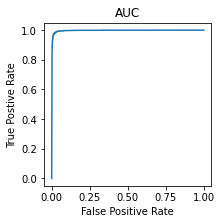

In [26]:
#AUC 계산
plt.figure(figsize=(3,3))
lab = np.array(ys)
p = np.array(outs)
fpr, tpr, thresholds = metrics.roc_curve(lab, p, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('AUC')
print('AUC: ',metrics.auc(fpr,tpr))